# dataset generator

In [1]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

In [2]:
# -*- coding: utf-8 -*-

# This code is part of Qiskit.
#
# (C) Copyright IBM 2018, 2020.
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.

"""
wine dataset
"""

import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA


def Wine(training_size, test_size, n, plot_data=False):
    """ returns wine dataset """
    class_labels = [r'A', r'B']

    data, target = datasets.load_wine(return_X_y=True)
    sample_train, sample_test, label_train, label_test = \
        train_test_split(data, target, test_size=test_size, random_state=7)

    # Now we standardize for gaussian around 0 with unit variance
    std_scale = StandardScaler().fit(sample_train)
    sample_train = std_scale.transform(sample_train)
    sample_test = std_scale.transform(sample_test)

    # Now reduce number of features to number of qubits
    pca = PCA(n_components=n).fit(sample_train)
    sample_train = pca.transform(sample_train)
    sample_test = pca.transform(sample_test)

    # Scale to the range (-1,+1)
    samples = np.append(sample_train, sample_test, axis=0)
    minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
    sample_train = minmax_scale.transform(sample_train)
    sample_test = minmax_scale.transform(sample_test)
    # Pick training size number of samples from each distro
    training_input = {key: (sample_train[label_train == k, :])[:training_size]
                      for k, key in enumerate(class_labels)}
    test_input = {key: (sample_test[label_test == k, :])[:test_size]
                  for k, key in enumerate(class_labels)}

    if plot_data:
        try:
            import matplotlib.pyplot as plt
        except ImportError:
            raise NameError('Matplotlib not installed. Please install it before plotting')
        for k in range(0, 2):
            plt.scatter(sample_train[label_train == k, 0][:training_size],
                        sample_train[label_train == k, 1][:training_size])

        plt.title("PCA dim. reduced Wine dataset")
        plt.show()

    return sample_train, training_input, test_input, class_labels

<IPython.core.display.Javascript object>


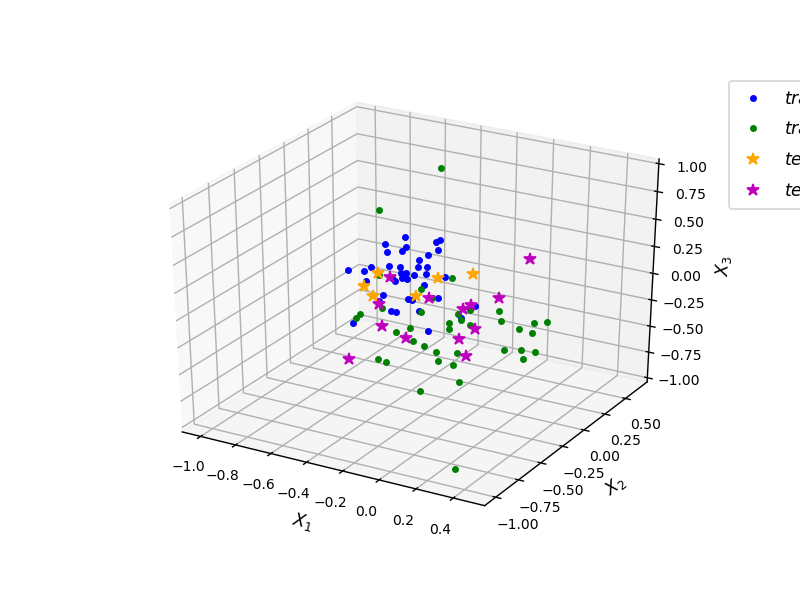

{'A': array([[ 0.79793355,  0.28187479, -0.33128971],
       [ 0.39343332, -0.08427555,  0.1119447 ],
       [ 0.40199003,  0.14214928, -0.32119205],
       [ 0.27183333, -0.03532283, -0.36099067],
       [ 0.24359139,  0.02226045, -0.086938  ],
       [ 0.49667755,  0.1744329 ,  0.20981907],
       [ 0.70254238,  0.54086689, -0.22133241],
       [ 0.43420364,  0.427876  ,  0.06947044],
       [ 0.6303877 ,  0.46178047, -0.22549449],
       [ 0.62597698,  0.31349661, -0.19044496],
       [ 0.58631141,  0.21263363, -0.11429097],
       [ 0.39582237,  0.1746587 , -0.10207793],
       [ 0.14338649,  0.06138962, -0.2394541 ],
       [ 0.80350035,  0.41282754, -0.19714028],
       [ 0.46880614,  0.40148459, -0.04646423],
       [ 0.57864998,  0.2269022 , -0.44634692],
       [ 0.51378791,  0.04245748, -0.30134363],
       [ 0.86872281,  0.71620827, -0.13805224],
       [ 0.57356045,  0.47232805, -0.15017466],
       [ 0.48668976,  0.25861296, -0.28062803]]), 'B': array([[ 0.39566165, -0.336

In [6]:
feature_dim = 3  # dimension of each data point
_, training_input, test_input, _ = Wine(training_size=20,
                                        test_size=20,
                                        n=feature_dim, plot_data=True)
print(training_input)
print(test_input)

# Variational Quantum Classifier (VQC)

In [7]:
from qiskit import BasicAer
from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit.aqua.algorithms import VQC
from qiskit.aqua.components.optimizers import COBYLA
from qiskit.aqua.components.feature_maps import RawFeatureVector
from qiskit.ml.datasets import wine
from qiskit.circuit.library import TwoLocal

seed = 1376
aqua_globals.random_seed = seed

# Use Wine data set for training and test data
feature_dim = 3  # dimension of each data point
_, training_input, test_input, _ = Wine(training_size=40,
                                        test_size=30,
                                        n=feature_dim)
#print(training_input)
#print(test_input)
feature_map = RawFeatureVector(feature_dimension=feature_dim)
vqc = VQC(COBYLA(maxiter=100),
          feature_map,
          TwoLocal(feature_map.num_qubits, ['ry', 'rz'], 'cz', reps=3),
          training_input,
          test_input)
result = vqc.run(QuantumInstance(BasicAer.get_backend('statevector_simulator'),
                                 shots=1024, seed_simulator=seed, seed_transpiler=seed))

print('Testing accuracy: {:0.2f}'.format(result['testing_accuracy']))

Testing accuracy: 0.84


In [8]:
from qiskit import Aer
from qiskit.aqua.utils import split_dataset_to_data_and_labels

In [9]:
datapoints, class_to_label = split_dataset_to_data_and_labels(test_input, class_names=None)
print("actual class:", datapoints[1])

actual class: [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [10]:
predicted_probs, predicted_labels = vqc.predict(datapoints[0])
#predicted_classes = map_label_to_class_name(predicted_labels, vqc.label_to_class)
print("prediction:   {}".format(predicted_labels))

prediction:   [0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1]


In [11]:
l=len(predicted_labels)
l
#datapoints[1][13]

for i in range(0,l):
    print(datapoints[0][i], 'actual class', datapoints[1][i], 'predicted', predicted_labels[i])
    #if datapoints[1][i] == predicted_labels[i]:

[-0.3106672   0.12257661 -0.00159093] actual class 0 predicted 0
[-0.35676171 -0.03458755 -0.10368263] actual class 0 predicted 0
[-0.56922088 -0.08888029 -0.14532   ] actual class 0 predicted 0
[-0.65562359  0.12632826 -0.08121702] actual class 0 predicted 0
[-0.2715842   0.43525216 -0.12280559] actual class 0 predicted 1
[-0.78448856  0.21788693 -0.30188076] actual class 0 predicted 0
[ 0.0338409  -0.29331844  0.06459403] actual class 1 predicted 1
[ 0.0730454  -0.28451819  0.10873265] actual class 1 predicted 1
[-0.12415542 -0.35235832  0.13485989] actual class 1 predicted 1
[-0.04005161 -1.          0.27533628] actual class 1 predicted 1
[ 0.18616375 -0.56251029 -0.15607619] actual class 1 predicted 1
[-0.14351306 -0.55893384 -0.11592039] actual class 1 predicted 1
[ 0.10816375 -0.48786503 -0.07013531] actual class 1 predicted 1
[-0.31612966 -0.38608836  0.27987904] actual class 1 predicted 1
[-0.3891037  -0.36775187 -0.00605781] actual class 1 predicted 1
[-0.47708695 -0.51904108 

In [12]:
datapoints_train, class_to_label_train = split_dataset_to_data_and_labels(training_input, class_names=None)
print(datapoints_train[1])
#print(datapoints_train[0])
print(len((datapoints_train[1])))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
80


0


<IPython.core.display.Javascript object>


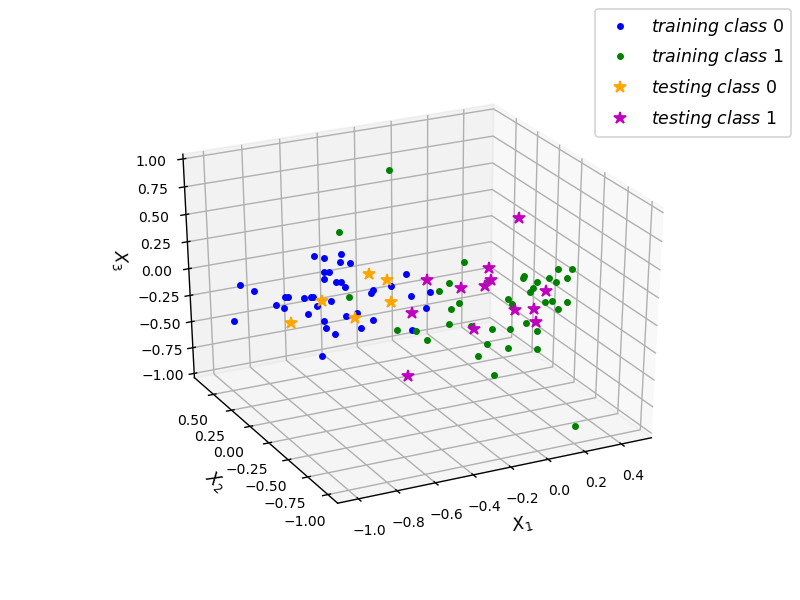

In [18]:
import numpy as np
import math
from scipy.optimize import minimize
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import minimize, minimize_scalar
from scipy import integrate
#%matplotlib inline
%matplotlib notebook
from mpl_toolkits import mplot3d

plt.rcParams.update({'font.size': 6})
mpl.rc('xtick', labelsize=8)
mpl.rc('ytick', labelsize=6)
#mpl.rc('ztick', labelsize=8)
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 10}

mpl.rc('font', **font)

def example_inline():
    plt.clf()
x0_train=[]
y0_train=[]
x0_test=[]
y0_test=[]
x1_train=[]
y1_train=[]
x1_test=[]
y1_test=[]

z0_train=[]
z1_train=[]
z0_test=[]
z1_test=[]
   
#plt.figure(1)    
for i in range(0, len(datapoints_train[0])):
    if datapoints_train[1][i]==0 :
        x0_train.append(datapoints_train[0][i][0])
        y0_train.append(datapoints_train[0][i][1])
        z0_train.append(datapoints_train[0][i][2])
       
        #plt.plot(datapoints_train[0][i][0], datapoints_train[0][i][1], linestyle='', linewidth = 3,
             #marker='o', markersize=3, color='blue', label= r'$Result ~from~ curve~ fitting$')
    else:
        x1_train.append(datapoints_train[0][i][0])
        y1_train.append(datapoints_train[0][i][1])
        z1_train.append(datapoints_train[0][i][2])
        #plt.plot(datapoints_train[0][i][0], datapoints_train[0][i][1], linestyle='', linewidth = 3,
                 #marker='o', markersize=3, color='green', label= r'$Result ~from~ curve$')
       

       
for i in range(0, len(datapoints[0])):
    if datapoints[1][i]==0 :
        x0_test.append(datapoints[0][i][0])
        y0_test.append(datapoints[0][i][1])
        z0_test.append(datapoints[0][i][2])
        #plt.plot(datapoints[0][i][0], datapoints[0][i][1], linestyle='', linewidth = 3,
             #marker='*', markersize=7, color='orange')
    else:
        x1_test.append(datapoints[0][i][0])
        y1_test.append(datapoints[0][i][1])
        z1_test.append(datapoints[0][i][2])
        
        #plt.plot(datapoints[0][i][0], datapoints[0][i][1], linestyle='', linewidth = 3,
                 #marker='*', markersize=7, color='m')    
    #plt.xlabel(r'$\mathbf{X_1}$')
    #plt.ylabel(r'$\mathbf{x_2}$')
#plt.legend()
    #plt.show()
print(len(x0_train)-len(y0_train))

   
plt.figure(1)
fig=plt.figure(1)
ax = plt.axes(projection='3d')
#ax.scatter3D(x0_train, y0_train, z0_train, linewidth = 3, linestyle='', marker='o', markersize=3, color='b', label= r'$training ~class~ 0$')
plt.plot(x0_train, y0_train, z0_train, linewidth = 3, linestyle='', marker='o', markersize=3, color='b', label= r'$training ~class~ 0$')

plt.plot(x1_train, y1_train, z1_train, linewidth = 3, linestyle='', marker='o', markersize=3, color='green', label= r'$training ~class~ 1$')

plt.plot(x0_test, y0_test, z0_test, linewidth = 3, linestyle='', marker='*', markersize=7, color='orange', label= r'$testing ~class~ 0$')

plt.plot(x1_test, y1_test,z1_test, linewidth = 3, linestyle='', marker='*', markersize=7, color='m', label= r'$testing ~class~ 1$')

ax.set_xlabel(r'$X_1$')
ax.set_ylabel(r'$X_2$')
ax.set_zlabel(r'$X_3$')
fig.legend()
#plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()
   


0


<IPython.core.display.Javascript object>


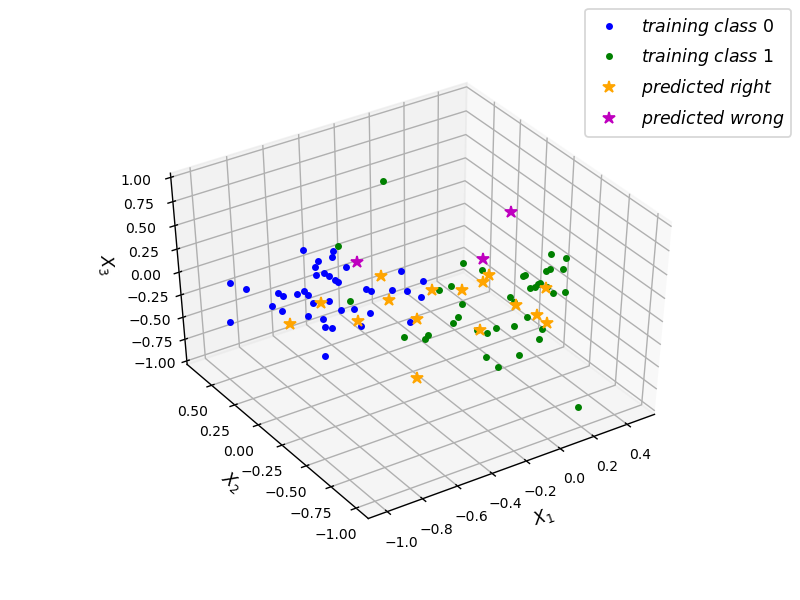

In [22]:
import numpy as np
import math
from scipy.optimize import minimize
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import minimize, minimize_scalar
from scipy import integrate
#%matplotlib inline
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import axes3d   

%matplotlib notebook

mpl.rcParams.update({'font.size': 8})
mpl.rc('xtick', labelsize=8)
mpl.rc('ytick', labelsize=8)
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 10}

mpl.rc('font', **font)

def example_inline():
    plt.clf()
x0_train=[]
y0_train=[]
x0_test=[]
y0_test=[]
x1_train=[]
y1_train=[]
x1_test=[]
y1_test=[]

z0_train=[]
z1_train=[]
z0_test=[]
z1_test=[]
   
#plt.figure(1)    
for i in range(0, len(datapoints_train[0])):
    if datapoints_train[1][i]==0 :
        x0_train.append(datapoints_train[0][i][0])
        y0_train.append(datapoints_train[0][i][1])
        z0_train.append(datapoints_train[0][i][2])
       
        #plt.plot(datapoints_train[0][i][0], datapoints_train[0][i][1], linestyle='', linewidth = 3,
             #marker='o', markersize=3, color='blue', label= r'$Result ~from~ curve~ fitting$')
    else:
        x1_train.append(datapoints_train[0][i][0])
        y1_train.append(datapoints_train[0][i][1])
        z1_train.append(datapoints_train[0][i][2])
        #plt.plot(datapoints_train[0][i][0], datapoints_train[0][i][1], linestyle='', linewidth = 3,
                 #marker='o', markersize=3, color='green', label= r'$Result ~from~ curve$')

for i in range(0, len(datapoints[0])):
    if datapoints[1][i]==predicted_labels[i] :
        x0_test.append(datapoints[0][i][0])
        y0_test.append(datapoints[0][i][1])
        z0_test.append(datapoints[0][i][2])
        #plt.plot(datapoints[0][i][0], datapoints[0][i][1], linestyle='', linewidth = 3,
             #marker='*', markersize=7, color='orange')
    else:
        x1_test.append(datapoints[0][i][0])
        y1_test.append(datapoints[0][i][1])
        z1_test.append(datapoints[0][i][2])
        #plt.plot(datapoints[0][i][0], datapoints[0][i][1], linestyle='', linewidth = 3,
                 #marker='*', markersize=7, color='m')    
    #plt.xlabel(r'$\mathbf{X_1}$')
    #plt.ylabel(r'$\mathbf{x_2}$')
#plt.legend()
    #plt.show()
print(len(x0_train)-len(y0_train))

   
plt.figure(1)
fig=plt.figure(1)
#ax = fig.gca(projection='3d')
ax = fig.add_subplot(111, projection='3d')

ax.plot(x0_train, y0_train, z0_train, linewidth = 3, linestyle='', marker='o', markersize=3, color='b', label= r'$training ~class~ 0$')

ax.plot(x1_train, y1_train,z1_train, linewidth = 3, linestyle='', marker='o', markersize=3, color='green', label= r'$training ~class~ 1$')

ax.plot(x0_test, y0_test,z0_test, linewidth = 3, linestyle='', marker='*', markersize=7, color='orange', label= r'$predicted~ right$')

plt.plot(x1_test, y1_test,z1_test, linewidth = 3, linestyle='', marker='*', markersize=7, color='m', label= r'$predicted ~wrong$')

ax.set_xlabel(r'$X_1$')
ax.set_ylabel(r'$X_2$')
ax.set_zlabel(r'$X_3$')
fig.legend()
#plt.legend(bbox_to_anchor=(1,1), loc="upper left")
#plt.legend(loc='best', bbox_to_anchor=(0.87, 0.5, 0.5, 0.5))
plt.show()


# Quantum Support vector Machine (QSVM)

In [21]:
from qiskit import BasicAer
from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit.aqua.algorithms import VQC
from qiskit.aqua.components.optimizers import COBYLA
from qiskit.aqua.components.feature_maps import RawFeatureVector
from qiskit.ml.datasets import ad_hoc_data
from qiskit.circuit.library import TwoLocal
from qiskit.aqua.components.feature_maps import SecondOrderExpansion
from qiskit.aqua.algorithms import QSVM

seed =  10598
aqua_globals.random_seed = seed

feature_dim = 2 # dimension of each data point
training_dataset_size = 20
testing_dataset_size = 10
#random_seed = 10598
#shots = 1024

#sample_Total, training_input, test_input, class_labels = ad_hoc_data(training_size=training_dataset_size, 
#                                                                     test_size=testing_dataset_size, 
#                                                                     n=feature_dim, gap=0.3, PLOT_DATA=True)

# Use Wine data set for training and test data
#feature_dim = 4  # dimension of each data point
# Use Wine data set for training and test data
feature_dim = 3  # dimension of each data point
_, training_input, test_input, _ = Wine(training_size=40,
                                        test_size=30,
                                        n=feature_dim)
#print(training_input)
#print(test_input)

#feature_map = RawFeatureVector(feature_dimension=feature_dim)
#feature_map =SecondOrderExpansion(feature_dimension=feature_dim, depth=2)
feature_map = SecondOrderExpansion(feature_dimension=feature_dim, depth=2, entangler_map=None, entanglement='full')

qsvmm = QSVM(feature_map, training_dataset=training_input, test_dataset=test_input, 
           datapoints=None, multiclass_extension=None, quantum_instance=None)

resultqsvm = qsvmm.run(QuantumInstance(BasicAer.get_backend('qasm_simulator'),
                                 shots=1024, seed_simulator=seed, seed_transpiler=seed))

print('Testing accuracy: {:0.2f}'.format(resultqsvm['testing_accuracy']))
#print(resultresultqsvm)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: DeprecationWarning: The qiskit.aqua.components.feature_maps.SecondOrderExpansion object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.ZZFeatureMap instead.
C:\ProgramData\Anaconda3\lib\site-packages\qiskit\aqua\components\feature_maps\second_order_expansion.py:59: DeprecationWarning: The qiskit.aqua.components.feature_maps.PauliZExpansion class is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.PauliFeatureMap instead.
  z_order=2, data_map_func=data_map_func)
C:\ProgramData\Anaconda3\lib\site-packages\qiskit\aqua\components\feature_maps\pauli_z_expansion.py:71: DeprecationWarning: The qiskit.aqua.components.feature_maps.PauliExpansion object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.libr

Testing accuracy: 0.89


In [23]:
from qiskit import Aer
from qiskit.aqua.utils import split_dataset_to_data_and_labels

In [24]:
datapoints, class_to_label = split_dataset_to_data_and_labels(test_input, class_names=None)
print(datapoints[0][18:])
#datapoints[0][2]

[[ 0.23220208 -0.56880888  0.11121532]]


In [25]:
import numpy as np
predicted_labels = qsvmm.predict(datapoints[0], quantum_instance=None)
#predicted_classes = map_label_to_class_name(predicted_labels, vqc.label_to_class)
print("prediction:   {}".format(predicted_labels))

prediction:   [0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 0 1]


In [26]:
for i in range(0,len(predicted_labels)):
    print(datapoints[0][i], 'actual class', datapoints[1][i], 'predicted', predicted_labels[i])

[-0.3106672   0.12257661 -0.00159093] actual class 0 predicted 0
[-0.35676171 -0.03458755 -0.10368263] actual class 0 predicted 0
[-0.56922088 -0.08888029 -0.14532   ] actual class 0 predicted 0
[-0.65562359  0.12632826 -0.08121702] actual class 0 predicted 0
[-0.2715842   0.43525216 -0.12280559] actual class 0 predicted 0
[-0.78448856  0.21788693 -0.30188076] actual class 0 predicted 0
[ 0.0338409  -0.29331844  0.06459403] actual class 1 predicted 1
[ 0.0730454  -0.28451819  0.10873265] actual class 1 predicted 1
[-0.12415542 -0.35235832  0.13485989] actual class 1 predicted 1
[-0.04005161 -1.          0.27533628] actual class 1 predicted 0
[ 0.18616375 -0.56251029 -0.15607619] actual class 1 predicted 1
[-0.14351306 -0.55893384 -0.11592039] actual class 1 predicted 1
[ 0.10816375 -0.48786503 -0.07013531] actual class 1 predicted 1
[-0.31612966 -0.38608836  0.27987904] actual class 1 predicted 1
[-0.3891037  -0.36775187 -0.00605781] actual class 1 predicted 1
[-0.47708695 -0.51904108 

In [27]:
datapoints_train, class_to_label_train = split_dataset_to_data_and_labels(training_input, class_names=None)
print(datapoints_train[1])
#print(datapoints_train[0])
print(len((datapoints_train[1])))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
80


In [28]:
datapoints_train[0][1][0]

-0.3991818439242424

0


<IPython.core.display.Javascript object>


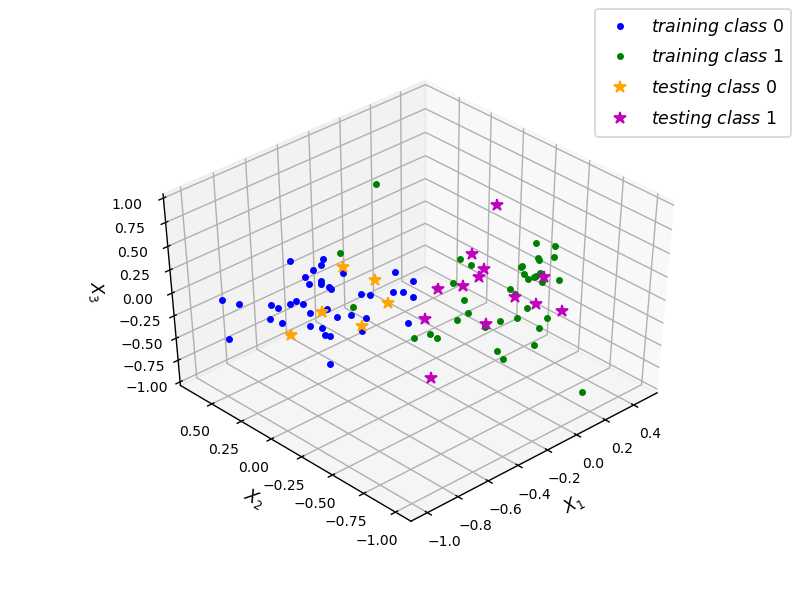

In [30]:
import numpy as np
import math
from scipy.optimize import minimize
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import minimize, minimize_scalar
from scipy import integrate
#%matplotlib inline
%matplotlib notebook
from mpl_toolkits import mplot3d

plt.rcParams.update({'font.size': 6})
mpl.rc('xtick', labelsize=8)
mpl.rc('ytick', labelsize=6)
#mpl.rc('ztick', labelsize=8)
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 10}

mpl.rc('font', **font)

def example_inline():
    plt.clf()
x0_train=[]
y0_train=[]
x0_test=[]
y0_test=[]
x1_train=[]
y1_train=[]
x1_test=[]
y1_test=[]

z0_train=[]
z1_train=[]
z0_test=[]
z1_test=[]
   
#plt.figure(1)    
for i in range(0, len(datapoints_train[0])):
    if datapoints_train[1][i]==0 :
        x0_train.append(datapoints_train[0][i][0])
        y0_train.append(datapoints_train[0][i][1])
        z0_train.append(datapoints_train[0][i][2])
       
        #plt.plot(datapoints_train[0][i][0], datapoints_train[0][i][1], linestyle='', linewidth = 3,
             #marker='o', markersize=3, color='blue', label= r'$Result ~from~ curve~ fitting$')
    else:
        x1_train.append(datapoints_train[0][i][0])
        y1_train.append(datapoints_train[0][i][1])
        z1_train.append(datapoints_train[0][i][2])
        #plt.plot(datapoints_train[0][i][0], datapoints_train[0][i][1], linestyle='', linewidth = 3,
                 #marker='o', markersize=3, color='green', label= r'$Result ~from~ curve$')
       

       
for i in range(0, len(datapoints[0])):
    if datapoints[1][i]==0 :
        x0_test.append(datapoints[0][i][0])
        y0_test.append(datapoints[0][i][1])
        z0_test.append(datapoints[0][i][2])
        #plt.plot(datapoints[0][i][0], datapoints[0][i][1], linestyle='', linewidth = 3,
             #marker='*', markersize=7, color='orange')
    else:
        x1_test.append(datapoints[0][i][0])
        y1_test.append(datapoints[0][i][1])
        z1_test.append(datapoints[0][i][2])
        
        #plt.plot(datapoints[0][i][0], datapoints[0][i][1], linestyle='', linewidth = 3,
                 #marker='*', markersize=7, color='m')    
    #plt.xlabel(r'$\mathbf{X_1}$')
    #plt.ylabel(r'$\mathbf{x_2}$')
#plt.legend()
    #plt.show()
print(len(x0_train)-len(y0_train))

   
plt.figure(1)
fig=plt.figure(1)
ax = plt.axes(projection='3d')
#ax.scatter3D(x0_train, y0_train, z0_train, linewidth = 3, linestyle='', marker='o', markersize=3, color='b', label= r'$training ~class~ 0$')
plt.plot(x0_train, y0_train, z0_train, linewidth = 3, linestyle='', marker='o', markersize=3, color='b', label= r'$training ~class~ 0$')

plt.plot(x1_train, y1_train, z1_train, linewidth = 3, linestyle='', marker='o', markersize=3, color='green', label= r'$training ~class~ 1$')

plt.plot(x0_test, y0_test, z0_test, linewidth = 3, linestyle='', marker='*', markersize=7, color='orange', label= r'$testing ~class~ 0$')

plt.plot(x1_test, y1_test,z1_test, linewidth = 3, linestyle='', marker='*', markersize=7, color='m', label= r'$testing ~class~ 1$')

ax.set_xlabel(r'$X_1$')
ax.set_ylabel(r'$X_2$')
ax.set_zlabel(r'$X_3$')
fig.legend()
#plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()
   


0


<IPython.core.display.Javascript object>


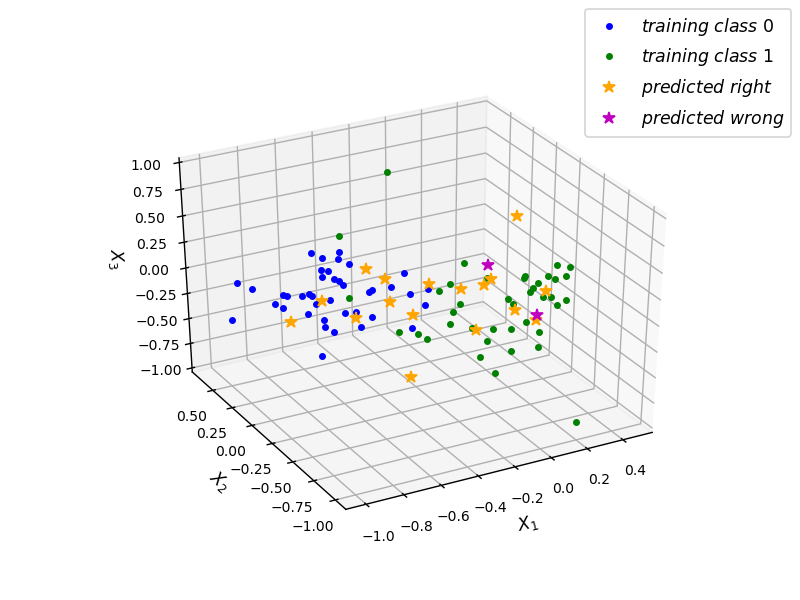

In [31]:
import numpy as np
import math
from scipy.optimize import minimize
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import minimize, minimize_scalar
from scipy import integrate
#%matplotlib inline
%matplotlib notebook
from mpl_toolkits import mplot3d

plt.rcParams.update({'font.size': 8})
mpl.rc('xtick', labelsize=8)
mpl.rc('ytick', labelsize=8)
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 10}

mpl.rc('font', **font)

def example_inline():
    plt.clf()
x0_train=[]
y0_train=[]
x0_test=[]
y0_test=[]
x1_train=[]
y1_train=[]
x1_test=[]
y1_test=[]

z0_train=[]
z1_train=[]
z0_test=[]
z1_test=[]
   
#plt.figure(1)    
for i in range(0, len(datapoints_train[0])):
    if datapoints_train[1][i]==0 :
        x0_train.append(datapoints_train[0][i][0])
        y0_train.append(datapoints_train[0][i][1])
        z0_train.append(datapoints_train[0][i][2])
       
        #plt.plot(datapoints_train[0][i][0], datapoints_train[0][i][1], linestyle='', linewidth = 3,
             #marker='o', markersize=3, color='blue', label= r'$Result ~from~ curve~ fitting$')
    else:
        x1_train.append(datapoints_train[0][i][0])
        y1_train.append(datapoints_train[0][i][1])
        z1_train.append(datapoints_train[0][i][2])
        #plt.plot(datapoints_train[0][i][0], datapoints_train[0][i][1], linestyle='', linewidth = 3,
                 #marker='o', markersize=3, color='green', label= r'$Result ~from~ curve$')

for i in range(0, len(datapoints[0])):
    if datapoints[1][i]==predicted_labels[i] :
        x0_test.append(datapoints[0][i][0])
        y0_test.append(datapoints[0][i][1])
        z0_test.append(datapoints[0][i][2])
        #plt.plot(datapoints[0][i][0], datapoints[0][i][1], linestyle='', linewidth = 3,
             #marker='*', markersize=7, color='orange')
    else:
        x1_test.append(datapoints[0][i][0])
        y1_test.append(datapoints[0][i][1])
        z1_test.append(datapoints[0][i][2])
        #plt.plot(datapoints[0][i][0], datapoints[0][i][1], linestyle='', linewidth = 3,
                 #marker='*', markersize=7, color='m')    
    #plt.xlabel(r'$\mathbf{X_1}$')
    #plt.ylabel(r'$\mathbf{x_2}$')
#plt.legend()
    #plt.show()
print(len(x0_train)-len(y0_train))

   
plt.figure(1)
fig=plt.figure(1)
ax = plt.axes(projection='3d')

plt.plot(x0_train, y0_train, z0_train, linewidth = 3, linestyle='', marker='o', markersize=3, color='b', label= r'$training ~class~ 0$')

plt.plot(x1_train, y1_train,z1_train, linewidth = 3, linestyle='', marker='o', markersize=3, color='green', label= r'$training ~class~ 1$')

plt.plot(x0_test, y0_test,z0_test, linewidth = 3, linestyle='', marker='*', markersize=7, color='orange', label= r'$predicted~ right$')

plt.plot(x1_test, y1_test,z1_test, linewidth = 3, linestyle='', marker='*', markersize=7, color='m', label= r'$predicted ~wrong$')

ax.set_xlabel(r'$X_1$')
ax.set_ylabel(r'$X_2$')
ax.set_zlabel(r'$X_3$')
fig.legend()
#plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()
   

In [91]:
print(len(datapoints[0]), len(datapoints_train[0]))

20 40
